# Sample Molecular Dynamics (MD) simulation code for LJ particle
## Velocity Verlet  + temperature control by velocity scaling or Nose-Hoover
2018, 2019, May, Tsuyoshi Okubo

In this code you can simulate dynamics of LJ particles with or without temperature control. Without temperature control, the total Hamiltoninan
$$ H =  \sum_{i} \frac{p_i^2}{2m_i} +\sum_{i} U(q_i)$$
is expected to be conserved. Here, 
* $q_i$ and $p_i$ : are coodinate and momentum, respectively.
In contrast, with temperature control, there is no conserved quantities. (Nose-Hoover is not a symplectec integrator for any Hamiltonians.)

In this code you can simulate dynamics of LJ particles by the Nose-Poincare-Andersen method. 
You can change four physical conditions:
* **N** : the number of particles
* **rho** : the initical density
* **T_set** : desired temperature (used only simulations with temperature control)

For simulation parameter you can set
* **dt** : time step for integral
* **step**: integral time steps. Total simulation time is dt * step.
* **obs_step**: physical quantities observed with this interval.

For temperature control
* **use_Nose_Hoover**: flag for using Nose-Hoover thermostad
* **Nose_tau**: characteristic time scall for Nose-Hoover thermostad. For details, please see the lecture slide.
* **use_velocity_scaling**: flag for using velosity scaling

Ref. 奥村久士, 「分子動力学シミュレーションにおける温度・圧力制御」、分子シミュレーション研究会会誌 “アンサンブル” (2008, 2009).


In [1]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline
from numba import jit ## for speed up, we use jit compile

In [2]:
## parameters for system
N=1000 # number of particles
rho = 0.8 #number density
T_set = 1.0 # temperature if Nose-Hoober or velocity_scaling is used

## parameters for integration
dt = 0.01 
step = 1000
obs_step = 10

## algorithm
use_Nose_Hoover = False #True
Nose_tau = 0.1
use_velocity_scaling = False #True


In [3]:
## initialization of parameter
L = (N/rho)**(1.0/3.0)

In [4]:
@jit(nopython = True)
def periodic_boundary(x,L):
    if np.abs(x) > L*0.5:
        x -= np.sign(x)*L
    return x

@jit(nopython = True)
def periodic_boundary_all(x,L):
    for i in range(N):
        x[i] = periodic_boundary(x[i],L)
    return x
@jit(nopython = True)
def force_lj(rx,ry,rz,L,r2_cut=2.5**2):
    ## calculate force, energy and virial for the LJ potential
    r2_inv = 1.0/r2_cut
    r6_inv = r2_inv**3
    pot_base = 4.0 * r6_inv * (r6_inv - 1.0)

    fx = np.zeros(N)
    fy = np.zeros(N)
    fz = np.zeros(N)
    Ep = 0.0
    virial = 0.0
    for i in range(N):
        for j in range(i+1,N):
            xij = periodic_boundary(rx[i]-rx[j],L)
            yij = periodic_boundary(ry[i]-ry[j],L)
            zij = periodic_boundary(rz[i]-rz[j],L)
            r2 = xij**2 + yij**2 + zij**2
            if r2 < r2_cut:
                r2_inv = 1.0/r2
                r6_inv = r2_inv**3
                
                f_factor = 48.0 * r6_inv * (r6_inv - 0.5)/r2
                fxi = f_factor * xij
                fyi = f_factor * yij
                fzi = f_factor * zij

                fx[i] += fxi
                fy[i] += fyi
                fz[i] += fzi

                fx[j] -= fxi
                fy[j] -= fyi
                fz[j] -= fzi

                Ep += 4.0 * r6_inv * (r6_inv - 1.0) - pot_base
                virial += fxi * xij + fyi * yij + fzi * zij
                
    
    Ep /= N
    return fx,fy,fz,Ep,virial

In [5]:
## initialization of variables
## simple cubic
rx = np.zeros(N)
ry = np.zeros(N)
rz = np.zeros(N)

px = np.zeros(N)
py = np.zeros(N)
pz = np.zeros(N)


l = N**(1.0/3.0)
d = (L-1.0)/l
nl = int(round(l))

ix = np.zeros(N,dtype=int)
iy = np.zeros(N,dtype=int)
iz = np.zeros(N,dtype=int)
for i in range(N):
    iz[i] = i/nl**2
    iy[i] = (i-iz[i] * nl**2)/nl
    ix[i] = i%nl
rx = -0.5 * L + d * ix + 0.5
ry = -0.5 * L + d * iy + 0.5
rz = -0.5 * L + d * iz + 0.5

rx = periodic_boundary_all(rx,L)
ry = periodic_boundary_all(ry,L)
rz = periodic_boundary_all(rz,L)
fx,fy,fz,Ep,virial = force_lj(rx,ry,rz,L)

Ek = 0.5 * np.sum(px**2 + py**2 + pz**2)/N
Pressure = (2.0 * N * Ek + virial)/(3.0*L**3)
H0 = Ep + Ek

Ep_dyn = [Ep]
Ek_dyn = [Ek]
Pressure_dyn = [Pressure]

## variables for Temeperature
zeta = 0.0
zeta_dyn = [zeta]


In [6]:
@jit(nopython = True)
def Velocity_Verlet(rx,ry,rz,px,py,pz,fx,fy,fz,dt,L):
    dt2 = dt * 0.5
    ## v: t + dt/2, r: t+dt
    px += fx * dt2
    py += fy * dt2
    pz += fz * dt2

    rx += px * dt
    ry += py * dt
    rz += pz * dt

    rx = periodic_boundary_all(rx,L)
    ry = periodic_boundary_all(ry,L)
    rz = periodic_boundary_all(rz,L)
    fx,fy,fz,Ep,virial = force_lj(rx,ry,rz,L)

    ## v: t + dt/2 + dt/2
    px += fx * dt2
    py += fy * dt2
    pz += fz * dt2

    Ek = 0.5 * np.sum(px**2 + py**2 + pz**2)/N
    
    return rx,ry,rz,px,py,pz,fx,fy,fz,Ep,Ek,virial

In [7]:
@jit(nopython = True)
def Velocity_Verlet_Nose(rx,ry,rz,px,py,pz,fx,fy,fz,zeta,dt,L,T_set,Nose_tau):
    dt2 = dt * 0.5
    exp_zeta = np.exp(-zeta*dt2)

    px *= exp_zeta
    py *= exp_zeta
    pz *= exp_zeta
    ## v: t + dt/2, r: t+dt
    px += fx * dt2
    py += fy * dt2
    pz += fz * dt2

    rx += px * dt
    ry += py * dt
    rz += pz * dt

    Ek = 0.5 * np.sum(px**2 + py**2 + pz**2)/N
    zeta += (2.0*Ek/3.0 - T_set)/Nose_tau**2 * dt
        
    rx = periodic_boundary_all(rx,L)
    ry = periodic_boundary_all(ry,L)
    rz = periodic_boundary_all(rz,L)
    fx,fy,fz,Ep,virial = force_lj(rx,ry,rz,L)

    ## v: t + dt/2 + dt/2
    px += fx * dt2
    py += fy * dt2
    pz += fz * dt2

    exp_zeta = np.exp(-zeta*dt2)
    px *= exp_zeta
    py *= exp_zeta
    pz *= exp_zeta
    
    Ek = 0.5 * np.sum(px**2 + py**2 + pz**2)/N
    
    return rx,ry,rz,px,py,pz,fx,fy,fz,zeta,Ep,Ek,virial

In [8]:
%%time
## main simulation part
for i in range(step):
    if use_Nose_Hoover:
        rx,ry,rz,px,py,pz,fx,fy,fz,zeta,Ep,Ek,virial = Velocity_Verlet_Nose(rx,ry,rz,px,py,pz,fx,fy,fz,zeta,dt,L,T_set,Nose_tau)
    else:
        rx,ry,rz,px,py,pz,fx,fy,fz,Ep,Ek,virial = Velocity_Verlet(rx,ry,rz,px,py,pz,fx,fy,fz,dt,L)
        if use_velocity_scaling:
            vfactor =np.sqrt(T_set/(Ek*2.0/3.0))
            px *= vfactor
            py *= vfactor
            pz *= vfactor
            Ek *= vfactor**2

    if i % obs_step == 0:
        Pressure = (2.0 * N * Ek + virial)/(3.0*L**3)

        Ep_dyn.append(Ep)
        Ek_dyn.append(Ek)
        Pressure_dyn.append(Pressure)

        ## variables for Temeperature
        zeta_dyn.append(zeta)


CPU times: user 3.77 s, sys: 22.5 ms, total: 3.79 s
Wall time: 3.82 s


In the followings, you can see dynamics of physicsal quantities.

Note that after initial "turbulence", energy, temperature and pressure become almost constant, which indicate the system is in equilibrium. With temperature controls, you can see the temperature is correctly controlled to the T_set

In adittion, without temperature control, the energy is stable without any drift behaviors.



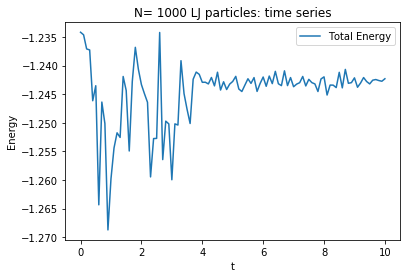

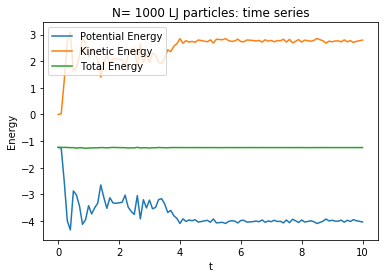

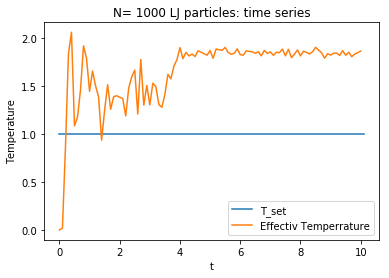

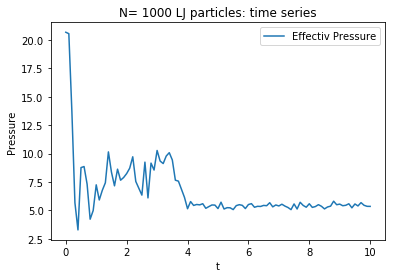

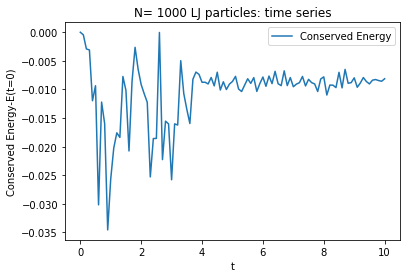

In [9]:
## plot time series
Ep = np.array(Ep_dyn)
Ek = np.array(Ek_dyn)
Pressure = np.array(Pressure_dyn)

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Energy")
pyplot.plot(np.arange(Ek.size)*dt*obs_step,Ek+Ep,label="Total Energy")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Energy")
pyplot.plot(np.arange(Ep.size)*dt*obs_step,Ep,label="Potential Energy")
pyplot.plot(np.arange(Ek.size)*dt*obs_step,Ek,label="Kinetic Energy")
pyplot.plot(np.arange(Ek.size)*dt*obs_step,Ek+Ep,label="Total Energy")
pyplot.legend()

pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Temperature")
pyplot.plot([0, Ep.size*dt*obs_step], [T_set, T_set],label="T_set")
pyplot.plot(np.arange(Ek.size)*dt*obs_step,2.0*Ek/3.0,label="Effectiv Temperrature")
pyplot.legend()


pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Pressure")
pyplot.plot(np.arange(Pressure.size)*dt*obs_step,Pressure,label="Effectiv Pressure")
pyplot.legend()


pyplot.figure()
pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("Conserved Energy-E(t=0)")
pyplot.plot(np.arange(Ep.size)*dt*obs_step,Ek+Ep-H0,label="Conserved Energy")
pyplot.legend()




pyplot.show()




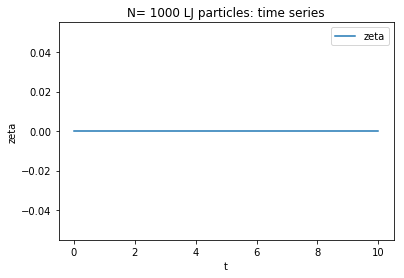

In [10]:
## plot thermostad variable
zeta = np.array(zeta_dyn)

pyplot.title("N= " + repr(N)+" LJ particles:"+ " time series")
pyplot.xlabel("t")
pyplot.ylabel("zeta")
pyplot.plot(np.arange(zeta.size)*dt*obs_step,zeta,label="zeta")
pyplot.legend()
pyplot.show()
